In [15]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
import seaborn as sns

figure_path = src.figures_path / "GRBs"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [17]:
grbs = pd.read_excel(src.external_data_path / "BorisLenhard_GRB_CNE_2017NatCom_SupTab1.xlsx", 
                     usecols=[0,1,2], names=src.coords)
grbs = grbs.sort_values(src.coords).reset_index(drop=True)
grbs['grb_uid'] = np.arange(grbs.shape[0], dtype=int)
grbs['length'] = grbs.end - grbs.start
grbs.head()

,chr,start,end,grb_uid,length
0,chr1,2717162,3634106,0,916944
1,chr1,4078428,6154459,1,2076031
2,chr1,6514538,7913366,2,1398828
3,chr1,8430770,8816800,3,386030
4,chr1,9431691,9950640,4,518949


In [19]:
extended = (4e6)
window_size = 5*1000

centered_grbs = grbs.copy()
centers = ((centered_grbs.start + centered_grbs.end)/2).astype(int)
centered_grbs['start'] = centers
centered_grbs['end'] = centers

centered_grbs = BedTool.from_dataframe(centered_grbs).slop(b=extended, genome='hg19').to_dataframe(names=centered_grbs.columns)
centered_grbs.head()

,chr,start,end,grb_uid,length
0,chr1,1,7175634,0,916944
1,chr1,1116443,9116443,1,2076031
2,chr1,3213952,11213952,2,1398828
3,chr1,4623785,12623785,3,386030
4,chr1,5691165,13691165,4,518949


In [20]:
centered_grbs = centered_grbs[centered_grbs.end - centered_grbs.start == extended*2]
windows = src.windowing_by_size(centered_grbs[src.coords + ['grb_uid']], window_size=window_size)

In [21]:
windows.head()

,chr,start,end,grb_uid,w_num
0,chr1,1116443,1121443,1,0
1,chr1,1121443,1126443,1,1
2,chr1,1126443,1131443,1,2
3,chr1,1131443,1136443,1,3
4,chr1,1136443,1141443,1,4


In [22]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


In [23]:
aggregations = {'n_cell_types': 'max'}


windows_with_bound = src.coverage_by_window(windows.sort_values(src.coords), consensus_boundaries.sort_values(src.coords), aggregations)
windows_with_bound = windows_with_bound.merge(centered_grbs.drop(src.coords, axis=1), on='grb_uid')
windows_with_bound.head()

,chr,start,end,grb_uid,w_num,n_cell_types,length
0,chr1,1116443,1121443,1,0,0,2076031
1,chr1,1121443,1126443,1,1,0,2076031
2,chr1,1126443,1131443,1,2,0,2076031
3,chr1,1131443,1136443,1,3,0,2076031
4,chr1,1136443,1141443,1,4,0,2076031


In [143]:
windows_with_grbs = src.coverage_by_window(windows.sort_values(src.coords), grbs.rename(columns={'grb_uid': 'gi'}).sort_values(src.coords), 
                                           {"gi": "max"})
windows_with_grbs.loc[windows_with_grbs.gi != windows_with_grbs.grb_uid, 'gi'] = 0
windows_with_grbs.head()

,chr,start,end,grb_uid,w_num,gi
0,chr1,1116443,1121443,1,0,0.0
1,chr1,1121443,1126443,1,1,0.0
2,chr1,1126443,1131443,1,2,0.0
3,chr1,1131443,1136443,1,3,0.0
4,chr1,1136443,1141443,1,4,0.0


In [146]:
grb_vs_windows = windows_with_bound.pivot_table(index='grb_uid', columns='w_num', values='n_cell_types')
length_vs_windows = windows_with_grbs.pivot_table(index='grb_uid', columns='w_num', values='gi')

In [132]:
X = grb_vs_windows.loc[grbs.sort_values('length', ascending=False).grb_uid.tolist()].fillna(0).values

min_cons = 2

X[X < min_cons] = 0
X[X >= min_cons] = 1

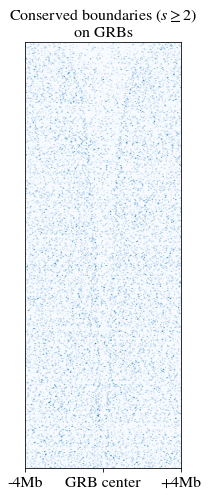

In [155]:
plt.figure(figsize=(3,7))
plt.imshow(X, aspect="auto", interpolation='bilinear', cmap='Blues')
plt.yticks([])
plt.xticks([0, int(X.shape[1]/2), X.shape[1] - 1], ['-4Mb', 'GRB center', "+4Mb"])
plt.title("Conserved boundaries ($s \geq 2$)\non GRBs")
plt.show()

In [153]:
L = length_vs_windows.loc[grbs.sort_values('length', ascending=False).grb_uid.tolist()].fillna(0).values
L[L > 0] = 1
L = L[L.sum(1) != 0]

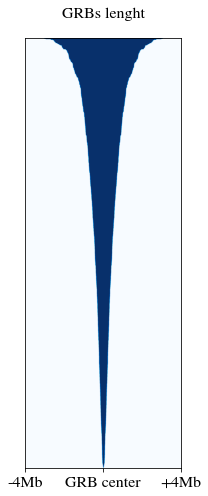

In [159]:
plt.figure(figsize=(3,7))
plt.imshow(L, aspect="auto", interpolation='bilinear', cmap='Blues')
plt.yticks([])
plt.xticks([0, int(X.shape[1]/2), X.shape[1] - 1], ['-4Mb', 'GRB center', "+4Mb"])
plt.title("GRBs lenght\n")
plt.show()